## Homework

In this homework, we'll deploy the dino or dragon model we trained in the 
[previous homework](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/08-deep-learning/homework.md).

Download the model from here: 

https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

In [ ]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

## Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the **converted** model?

* 21 Mb
* **43 Mb**
* 80 Mb
* 164 Mb

In [4]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('dino_dragon_10_0.899.h5')

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
____________________________________________

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('dino_dragon_10_0.899.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\darkcorp\AppData\Local\Temp\tmpybql80tc\assets


INFO:tensorflow:Assets written to: C:\Users\darkcorp\AppData\Local\Temp\tmpybql80tc\assets


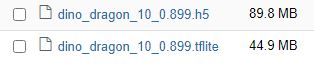

## Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

What's the output index for this model?

* 3
* 7
* **13**
* 24

In [7]:
import tensorflow.lite as tflite

interpreter = tflite.Interpreter(model_path='dino_dragon_10_0.899.tflite')
interpreter.allocate_tensors()

In [8]:
interpreter.get_input_details()

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3]),
  'shape_signature': array([ -1, 150, 150,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [9]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## Preparing the image


For that, you'll need to have `pillow` installed:

In [ ]:
pip install pillow

You'll need some code for downloading and resizing images. You can use 
this code:

In [11]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

Let's download and resize this image: 

https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg

Based on the previous homework, what should be the target size for the image?

In [38]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'
img = download_image(url)

target_size = (150, 150)
prep_img = prepare_image(img, target_size)

## Question 3

Now we need to turn the image into numpy array and pre-process it. 

> Tip: Check the previous homework. What was the pre-processing 
> we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3353411
* **0.5529412**
* 0.7458824
* 0.9654902

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

#preprocess the image
x = image.img_to_array(prep_img)/255
x = x.reshape((1,) + x.shape)

#R channel of the first pixel of RGB
x[0][0][0][0]

0.5529412

## Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.17049132
* 0.39009996
* 0.60146114
* **0.82448614**

In [62]:
preds = model.predict(x)
preds[0][0]

1/1 [==============================] - 0s 33ms/step


0.82448554

## Prepare the lambda code 

Now you need to copy all the code into a separate python file. You will 
need to use this file for the next two questions.

Tip: you can test this file locally with `ipython` or Jupyter Notebook 
by importing the file and invoking the function from this file.  

In [ ]:
!pip install keras-image-helper

In [ ]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

#### hw_lambda_function.py


```python
#!/usr/bin/env python
# coding: utf-8

import tflite_runtime.interpreter as tflite
import numpy as np
from io import BytesIO
from urllib import request
from PIL import Image

target_size = (150, 150)
classes = ['dino', 'dragon']

interpreter = tflite.Interpreter(model_path='dino_dragon_10_0.899.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

def predict(url):
    img = download_image(url)
    img = prepare_image(img, target_size)
    X = np.asarray(img, dtype=np.float32)
    X = X.reshape((1,) + X.shape)/255

    interpreter.set_tensor(input_index, X)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_index)

    float_predictions = preds[0].tolist()

    return dict(zip(classes, float_predictions))

def lambda_handler(event, context):
    url = event['url']
    result = predict(url)
    return result
```

In [ ]:
import hw_lambda_function
hw_lambda_function.predict('https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg')

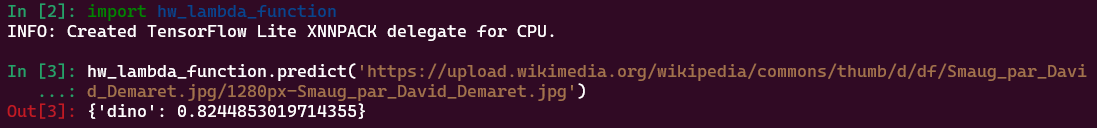

In [ ]:
event = {'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'}
hw_lambda_function.lambda_handler(event, None)

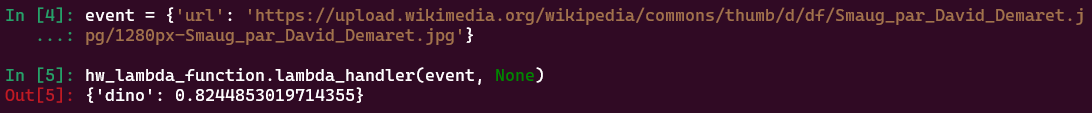

## Docker 

For the next two questions, we'll use a Docker image that we already 
prepared. This is the Dockerfile that we used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.9
COPY dino-vs-dragon-v2.tflite .
```

And pushed it to [`svizor42/zoomcamp-dino-dragon-lambda:v2`](https://hub.docker.com/r/svizor42/zoomcamp-dino-dragon-lambda/tags).

A few notes:

* The image already contains a model and it's not the same model
  as the one we used for questions 1-4.
* The version of Python is 3.9, so you need to use the right wheel for 
  TF-Lite. For Tensorflow 2.7.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl

#### Dockerfile
```docker
FROM svizor42/zoomcamp-dino-dragon-lambda:v2

RUN pip install numpy
RUN pip install pillow
RUN pip install https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl

COPY hw_lambda_function.py .

CMD [ "hw_lambda_function.lambda_handler" ]
```

```docker build -t dino-vs-dragon-v2 .```

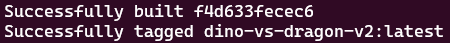

#### my_test.py

```python
import requests

url = 'http://localhost:8080/2015-03-31/functions/function/invocations'

data = {'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'}

result = requests.post(url, json=data).json()
print(result)
```

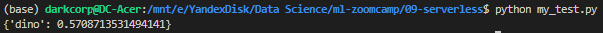

## Question 5

Download the base image `svizor42/zoomcamp-dino-dragon-lambda:v2`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

* 139 Mb
* 329 Mb
* **639 Mb**
* 929 Mb

You can get this information when running `docker images` - it'll be in the "SIZE" column.

```
$ sudo service docker start
```
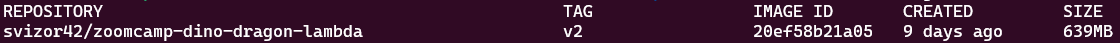

## Question 6

Now let's extend this docker image, install all the required libraries
and add the code for lambda.

You don't need to include the model in the image. It's already included. 
The name of the file with the model is `dino-vs-dragon-v2.tflite` and it's 
in the current workdir in the image (see the Dockerfile above for the 
reference).

Now run the container locally.

Score this image: https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg

What's the output from the model?

* 0.12
* **0.32**
* 0.52
* 0.72

#### my_test.py
```python
import requests

url = 'http://localhost:8080/2015-03-31/functions/function/invocations'

data = {'url': 'https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg'}

result = requests.post(url, json=data).json()
print(result)
```

`docker run -it --rm -p 8080:8080 dino-vs-dragon-v2:latest`

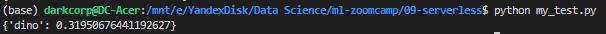

## Publishing it to AWS

Now you can deploy your model to AWS!

* Publish your image to ECR
* Create a lambda function in AWS, use the ECR image
* Give it more RAM and increase the timeout 
* Test it
* Expose the lambda function using API Gateway

This is optional and not graded.


## Publishing to Docker hub

This is just for reference, this is how we published our image to Docker hub:

```bash
docker build -t zoomcamp-dino-dragon-lambda .
docker tag zoomcamp-dino-dragon-lambda:latest svizor42/zoomcamp-dino-dragon-lambda:v2
docker push svizor42/zoomcamp-dino-dragon-lambda:v2
```


## Submit the results

* Submit your results here: https://forms.gle/Pnx563ELg9jgjxHX6
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is **28 November 2022 (Monday), 23:00 CEST (Berlin time)**. 

After that, the form will be closed.